In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [2]:
torch.cuda.empty_cache()

In [3]:
# Redefine Resnet BasicBlock (For BN choice)
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, with_BN, stride=1):
    super(BasicBlock, self).__init__()
    self.with_BN = with_BN

    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    if with_BN:
      self.bn1 = nn.BatchNorm2d(planes)

    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    if with_BN:
      self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential() # identity mapping
    if stride != 1:
      modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
      if with_BN:
        modules.append(nn.BatchNorm2d(planes))
      self.shortcut = nn.Sequential(*modules)

  def forward(self, x):
    if self.with_BN:
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
    else:
      out = F.relu(self.conv1(x))
      out = self.conv2(out)
    out += self.shortcut(x) # skip connection
    out = F.relu(out)
    return out

In [4]:
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, with_BN, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64
    self.with_BN = with_BN

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    if self.with_BN:
      self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block , 64, with_BN, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
    self.linear = nn.Linear(512, num_classes)

  def _make_layer(self, block, planes, with_BN, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, with_BN, stride=stride))
      self.in_planes = planes
    return nn.Sequential(*layers)
  
  def forward(self, x):
    if self.with_BN:
      out = F.relu(self.bn1(self.conv1(x)))
    else:
      out = F.relu(self.conv1(x))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [5]:
def ResNet18(with_BN):
  return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

In [6]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
                                       transforms.RandomCrop(32, padding=4),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
])
transform_test = transforms.Compose([
                                      transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
def train(net, optimizer, epoch, step):
  net.train()
  correct = 0
  total = 0
  steps = []
  losses = []

  for _, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    # loss
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    # accuracy
    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item()
    total += targets.size(0)

    steps.append(step)
    losses.append(loss.item())
    step += 1

  return correct / total, steps, losses

In [46]:
def test(net, epoch):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss += criterion(outputs, targets).item()

      _, predicted = outputs.max(1)
      correct += predicted.eq(targets).sum().item()
      total += targets.size(0)

  return correct / total, loss

In [10]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1dba727f376af1291c950863b5509ac443ff3f0ca58579fb0a3b3996bda15d31
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [11]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


# Without BN

In [12]:
print("Initialize parameters")
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay = 0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total number of parameters: ", total_params)

Initialize parameters
Total number of parameters:  11164362


In [48]:
without_BN_steps = []
without_BN_train_accuracies = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(epochs):
  print(f'[Epoch: {epoch}/{epochs}]')
  train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
  without_BN_train_accuracies.append(train_accuracy)
  without_BN_steps.extend(steps)
  without_BN_train_losses.extend(train_losses)
  print(f'Train accuracy  = {train_accuracy * 100: .2f} / Train loss = {sum(train_losses)}')

  test_accuracy, test_loss = test(net, epoch)
  without_BN_test_accuracies.append(test_accuracy)
  without_BN_test_losses.append(test_loss)
  print(f'Test accuracy = {test_accuracy * 100: .2f} / Test loss = {test_loss}')

[Epoch: 0/20]
Train accuracy  =  93.96 / Train loss = 67.1564313210547
Test accuracy =  88.89 / Test loss = 37.949990689754486
[Epoch: 1/20]


KeyboardInterrupt: ignored

# With BN

In [14]:
print("Initialize parameters")
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay = 0.0002)

total_params = sum(p.numel() for p  in net.parameters() if p.requires_grad)
print("Total number of parameters: ", total_params)

Initialize parameters
Total number of parameters:  11173962


In [15]:
with_BN_steps = []
with_BN_train_accuracies = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(epochs):
  print(f'[Epoch: {epoch}/{epochs}]')
  train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
  with_BN_train_accuracies.append(train_accuracy)
  with_BN_steps.extend(steps)
  with_BN_train_losses.extend(train_losses)
  print(f'Train accuracy  = {train_accuracy * 100: .2f} / Train loss = {sum(train_losses)}')

  test_accuracy, test_loss = test(net, epoch)
  with_BN_test_accuracies.append(test_accuracy)
  with_BN_test_losses.append(test_loss)
  print(f'Test accuracy = {test_accuracy * 100: .2f} / Test loss = {test_loss}')

[Epoch: 0/20]
Train accuracy  =  48.68 / Train loss = 553.3231010437012
Test accuracy =  59.21 / Test loss = 122.65010070800781
[Epoch: 1/20]
Train accuracy  =  67.40 / Train loss = 361.21172922849655
Test accuracy =  69.96 / Test loss = 86.34224700927734
[Epoch: 2/20]
Train accuracy  =  74.52 / Train loss = 284.3754900097847
Test accuracy =  66.82 / Test loss = 105.14801788330078
[Epoch: 3/20]
Train accuracy  =  79.13 / Train loss = 236.11412942409515
Test accuracy =  78.84 / Test loss = 62.98850631713867
[Epoch: 4/20]
Train accuracy  =  81.73 / Train loss = 207.37004300951958
Test accuracy =  77.31 / Test loss = 70.47621154785156
[Epoch: 5/20]
Train accuracy  =  83.67 / Train loss = 183.6508515626192
Test accuracy =  79.49 / Test loss = 62.626251220703125
[Epoch: 6/20]
Train accuracy  =  85.33 / Train loss = 165.91451163589954
Test accuracy =  81.35 / Test loss = 54.685787200927734
[Epoch: 7/20]
Train accuracy  =  86.42 / Train loss = 152.641196295619
Test accuracy =  82.54 / Test lo

# without_BN VS with_BN

In [16]:
print('without_BN')

without_BN


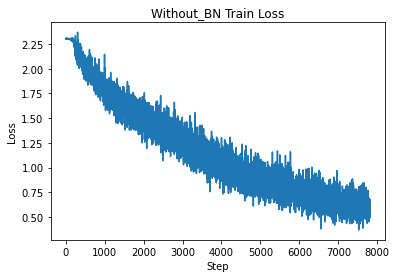

In [17]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Without_BN Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

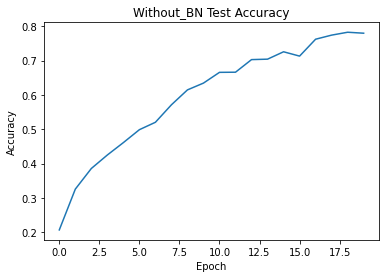

AttributeError: ignored

In [47]:
import numpy
plt.plot([i for i in range(epochs)], without_BN_test_accuracies)
plt.title('Without_BN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(epochs)], without_BN_test_losses.item())
plt.title('Without_BN Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
print('with_BN')

In [ ]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('With_BN Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot([i for i in range(epochs)], with_BN_test_accuracies)
plt.title('With_BN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(epochs)], with_BN_test_losses)
plt.title('With_BN Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Draw those two on one plot and compare them!

In [ ]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlable('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

- batch normalization을 이용하면 loss값의 변동 폭이 작아짐을 확인할 수 있다.
- 성능 또한 개선되는 것이 확인되며, 특히나 초반에 loss값이 줄어드는 속도가 현저히 빠르다.

In [ ]:
plt.plot([i for i in range(epochs)], without_BN_test_accuracies)
plt.plot([i for i in range(epochs)], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(epochs)], without_BN_test_losses)
plt.plot([i for i in range(epochs)], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show() 